In [ ]:
import os
import shutil
import zipfile
import re
from pathlib import Path
import requests
from tqdm import tqdm
import cv2
import albumentations as A

2026-01-12 15:11:41.765671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset

## Downloading & extraction

In [ ]:
# Function to download the dataset
def download_file(url, dest):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte
    with open(dest, 'wb') as file, tqdm(
        desc="Downloading zip file",
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            bar.update(len(data))
            file.write(data)

# Function to extract the zip file
def extract_zip_with_progress(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        total_files = len(zip_ref.infolist())
        with tqdm(total=total_files, desc="Extracting zip file") as pbar:
            for file in zip_ref.infolist():
                zip_ref.extract(file, extract_to)
                pbar.update(1)

# Function to organize and sort images
def organize_and_save(src_dir, dst_dir_a, dst_dir_b):
    files = sorted(os.listdir(src_dir))
    half_index = len(files) // 2  # Calculate the split index
    with tqdm(total=len(files), desc=f"Saving files from {src_dir}") as pbar:
        for i, filename in enumerate(files):
            if filename.endswith('.png'):
                img_path = os.path.join(src_dir, filename)
                if i < half_index:
                    os.rename(img_path, os.path.join(dst_dir_a, filename))
                else:
                    os.rename(img_path, os.path.join(dst_dir_b, filename))
                pbar.update(1)

# "The dataset is available from Liang et al. (2021) at the following link: https://doi.org/10.5281/zenodo.4722095."
# or
# "The dataset is available from Liang et al. (2022) at the following link: https://doi.org/10.1016/j.cageo.2022.105217"

# Download the zip file
url = "https://zenodo.org/records/4722095/files/Bent_data_624.zip?download=1"
zip_path = "kaggle/working/Bent_data_624.zip"
# download_file(url, zip_path)


In [ ]:
# Extract the zip file
# extract_zip_with_progress(zip_path, "/home/ridho/thesis/kaggle/working")

# Remove the zip file
# os.remove(zip_path)
# print("Zip file removed")

# Define source and destination paths
source_dir = "kaggle/working/Bent_data_624"
sample_c_inputs = "kaggle/working/sample_c/inputs"
sample_c_labels = "kaggle/working/sample_c/labels"
sample_a_inputs = "kaggle/working/sample_a/inputs"
sample_a_labels = "kaggle/working/sample_a/labels"
sample_b_inputs = "kaggle/working/sample_b/inputs"
sample_b_labels = "kaggle/working/sample_b/labels"

# Create destination directories
os.makedirs(sample_c_inputs, exist_ok=True)
os.makedirs(sample_c_labels, exist_ok=True)
os.makedirs(sample_a_inputs, exist_ok=True)
os.makedirs(sample_a_labels, exist_ok=True)
os.makedirs(sample_b_inputs, exist_ok=True)
os.makedirs(sample_b_labels, exist_ok=True)


In [5]:
# Resize and move files
organize_and_save(os.path.join(source_dir, "image_test"), sample_c_inputs, sample_c_inputs)
organize_and_save(os.path.join(source_dir, "mask_test"), sample_c_labels, sample_c_labels)
organize_and_save(os.path.join(source_dir, "image_train_valid_XYZ"), sample_a_inputs, sample_b_inputs)
organize_and_save(os.path.join(source_dir, "mask_train_valid_XYZ"), sample_a_labels, sample_b_labels)

# Delete the old folder
shutil.rmtree(source_dir)
print("Old folder deleted")

print("All files have been organized, resized, and sorted")

Saving files from /home/ridho/thesis/kaggle/working/Bent_data_624/image_test: 100%|██████████| 1872/1872 [00:00<00:00, 24718.20it/s]
Saving files from /home/ridho/thesis/kaggle/working/Bent_data_624/mask_test: 100%|██████████| 1872/1872 [00:00<00:00, 24190.83it/s]
Saving files from /home/ridho/thesis/kaggle/working/Bent_data_624/image_train_valid_XYZ: 100%|██████████| 3744/3744 [00:00<00:00, 25638.33it/s]
Saving files from /home/ridho/thesis/kaggle/working/Bent_data_624/mask_train_valid_XYZ: 100%|██████████| 3744/3744 [00:00<00:00, 26299.70it/s]

Old folder deleted
All files have been organized, resized, and sorted


## Train & validation data prepration

In [ ]:
# =========================
# CONFIG
# =========================
ROOT_DIR = Path("/home/ridho/thesis/kaggle/working")
SAMPLES = ["sample_a", "sample_b"]
AXES = ["X", "Y", "Z"]
SEQUENCE_LENGTH = 624
TARGET_SUBSEQUENCES = 40

OUTPUT_DIR = ROOT_DIR / "subsequences"
TRAIN_DIR = OUTPUT_DIR / "train"
VAL_DIR = OUTPUT_DIR / "validation"

TRAIN_DIR.mkdir(parents=True, exist_ok=True)
VAL_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# HELPERS
# =========================
def extract_index(filename):
    """Extract slice index from filename (e.g., Bentheimer_A_X_624123.png -> 624123)"""
    match = re.search(r"_(\d+)\.png$", filename)
    return int(match.group(1)) if match else None

# =========================
# COLLECT IMAGES
# =========================
print("Collecting images from samples...")
all_sequences = []

for sample in SAMPLES:
    sample_dir = ROOT_DIR / sample
    input_dir = sample_dir / "inputs"
    label_dir = sample_dir / "labels"

    for axis in AXES:
        # Collect and sort files for this axis
        input_files = sorted(
            [f for f in os.listdir(input_dir) if f"_{axis}_" in f],
            key=extract_index
        )
        
        if len(input_files) != SEQUENCE_LENGTH:
            print(f"Warning: {sample} axis {axis} has {len(input_files)} files")

        all_sequences.append({
            'sample': sample,
            'axis': axis,
            'input_dir': input_dir,
            'label_dir': label_dir,
            'files': input_files
        })

# =========================
# CREATE SUBSEQUENCES WITH TRAIN/VAL SPLIT
# =========================
total_images = sum(len(seq['files']) for seq in all_sequences)
approx_subseq_len = total_images // TARGET_SUBSEQUENCES

print(f"Total sequences: {len(all_sequences)}")
print(f"Total images: {total_images}")
print(f"Target subsequence length ≈ {approx_subseq_len}")

print("\nCreating subsequences with train/val split...")
subseq_counter = 1

for seq_info in all_sequences:
    images = seq_info['files']
    n = len(images)
    
    # Calculate split for this sequence
    subseqs_here = round(n / approx_subseq_len)
    subseq_len = n // subseqs_here
    
    for i in range(subseqs_here):
        start = i * subseq_len
        end = n if i == subseqs_here - 1 else (i + 1) * subseq_len
        
        # Determine train or validation
        dest_base = VAL_DIR if subseq_counter % 5 == 0 else TRAIN_DIR
        split_name = "validation" if subseq_counter % 5 == 0 else "train"
        
        subseq_name = f"subsequence_{subseq_counter:03d}"
        out_input = dest_base / subseq_name / "inputs"
        out_label = dest_base / subseq_name / "labels"
        
        out_input.mkdir(parents=True, exist_ok=True)
        out_label.mkdir(parents=True, exist_ok=True)
        
        # Copy files
        for fname in images[start:end]:
            shutil.copy(seq_info['input_dir'] / fname, out_input / fname)
            shutil.copy(seq_info['label_dir'] / fname, out_label / fname)
        
        print(
            f"{subseq_name} → {split_name}: "
            f"{seq_info['sample']}_{seq_info['axis']} [{start}:{end}] → {end - start} images"
        )
        
        subseq_counter += 1

print(f"\nCreated {subseq_counter - 1} subsequences")
print(f"   Train: {len(list(TRAIN_DIR.iterdir()))} subsequences")
print(f"   Validation: {len(list(VAL_DIR.iterdir()))} subsequences")

Step 1: Collecting images from samples...
Total sequences: 6
Total images: 3744
Target subsequence length ≈ 93

Step 2: Creating subsequences with train/val split...
subsequence_001 → train: sample_a_X [0:89] → 89 images
subsequence_002 → train: sample_a_X [89:178] → 89 images
subsequence_003 → train: sample_a_X [178:267] → 89 images
subsequence_004 → train: sample_a_X [267:356] → 89 images
subsequence_005 → validation: sample_a_X [356:445] → 89 images
subsequence_006 → train: sample_a_X [445:534] → 89 images
subsequence_007 → train: sample_a_X [534:624] → 90 images
subsequence_008 → train: sample_a_Y [0:89] → 89 images
subsequence_009 → train: sample_a_Y [89:178] → 89 images
subsequence_010 → validation: sample_a_Y [178:267] → 89 images
subsequence_011 → train: sample_a_Y [267:356] → 89 images
subsequence_012 → train: sample_a_Y [356:445] → 89 images
subsequence_013 → train: sample_a_Y [445:534] → 89 images
subsequence_014 → train: sample_a_Y [534:624] → 90 images
subsequence_015 → va

## Train & validation data preprocessing, augmentation and generators

### Preprocessing and Augmentation

In [ ]:
# =========================
# AUGMENTATION
# =========================

print("\nApplying augmentation...")

IMAGE_SIZE = (512, 512)  # (height, width)

# Augmentation pipeline with ReplayCompose for temporal consistency
transform = A.ReplayCompose([
    A.OneOf([
        A.RandomCrop(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1], p=1.0),
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1])
    ], p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5, border_mode=cv2.BORDER_REFLECT),
    A.Affine(scale=(0.95, 1.05), translate_percent=(-0.05, 0.05), rotate=0, p=0.5, border_mode=cv2.BORDER_REFLECT),
])

# Process both train and validation splits
for split_dir in [TRAIN_DIR, VAL_DIR]:
    split_name = split_dir.name
    subsequence_folders = sorted([d for d in split_dir.iterdir() if d.is_dir()])
    
    for sub_folder in subsequence_folders:
        input_dir = sub_folder / 'inputs'
        label_dir = sub_folder / 'labels'
        
        image_files = sorted([f for f in input_dir.iterdir() if f.suffix == '.png'])
        
        replay_data = None
        
        for image_file in image_files:
            mask_file = label_dir / image_file.name
            
            # Read image and mask
            image = cv2.imread(str(image_file))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(str(mask_file), cv2.IMREAD_GRAYSCALE)
            
            if image is None or mask is None:
                print(f"Warning: Skipping missing image/mask for {image_file.name}")
                continue
            
            # Apply transform with temporal consistency
            if replay_data is None:
                augmented = transform(image=image, mask=mask)
                replay_data = augmented['replay']
            else:
                augmented = A.ReplayCompose.replay(replay_data, image=image, mask=mask)
            
            aug_image = augmented['image']
            aug_mask = augmented['mask']
            
            # Overwrite original files with augmented versions
            cv2.imwrite(str(image_file), cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
            cv2.imwrite(str(mask_file), aug_mask)
        
        print(f"Augmented {sub_folder.name} ({split_name})")

print("\nAugmentation complete!")


Step 3: Applying augmentation...
Augmented subsequence_001 (train)
Augmented subsequence_002 (train)
Augmented subsequence_003 (train)
Augmented subsequence_004 (train)
Augmented subsequence_006 (train)
Augmented subsequence_007 (train)
Augmented subsequence_008 (train)
Augmented subsequence_009 (train)
Augmented subsequence_011 (train)
Augmented subsequence_012 (train)
Augmented subsequence_013 (train)
Augmented subsequence_014 (train)
Augmented subsequence_016 (train)
Augmented subsequence_017 (train)
Augmented subsequence_018 (train)
Augmented subsequence_019 (train)
Augmented subsequence_021 (train)
Augmented subsequence_022 (train)
Augmented subsequence_023 (train)
Augmented subsequence_024 (train)
Augmented subsequence_026 (train)
Augmented subsequence_027 (train)
Augmented subsequence_028 (train)
Augmented subsequence_029 (train)
Augmented subsequence_031 (train)
Augmented subsequence_032 (train)
Augmented subsequence_033 (train)
Augmented subsequence_034 (train)
Augmented subs

### Generator

In [1]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import distance_transform_edt


2026-01-12 21:27:29.658582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
NUM_CLASSES = 4
SEQUENCE_LENGTH = 7 # Change sequence length here
BATCH_SIZE = 1
IMG_CHANNELS = 1

weights = [0.04009848191458308, 0.010983016095772147, 0.5302805714469324, 0.4186379305427124]

In [3]:
# -------------------------------------------------
# Utility: Load all subsequences
# -------------------------------------------------
def load_subsequences(base_dir, sequence_length):
    subsequences = []
    for subseq_dir in sorted(os.listdir(base_dir)):
        seq_path = os.path.join(base_dir, subseq_dir)
        img_dir = os.path.join(seq_path, "inputs")
        mask_dir = os.path.join(seq_path, "labels")

        if not os.path.isdir(img_dir) or not os.path.isdir(mask_dir):
            continue

        images = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".png")])
        masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")])

        assert len(images) == len(masks), f"Image/mask mismatch in {seq_path}"

        for i in range(0, len(images) - sequence_length + 1):
            subsequences.append((images[i:i+sequence_length], masks[i:i+sequence_length]))
    print(len(subsequences) // 44)

    return subsequences

# -------------------------------------------------
# Generator: sequence → last mask
# -------------------------------------------------
def sequence_generator(base_dir, batch_size, sequence_length, shuffle=True):
    sequences = load_subsequences(base_dir, sequence_length)
    
    np.random.seed(42) 
    while True:
        if shuffle:
            np.random.shuffle(sequences)

        for i in range(0, len(sequences), batch_size):
            batch = sequences[i:i+batch_size]

            batch_images, batch_masks = [], []
            for img_paths, mask_paths in batch:
                seq_images = []
                for img_file in img_paths:
                    img = tf.io.decode_png(tf.io.read_file(img_file), channels=1)
                    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH], method="nearest")
                    img = tf.cast(img, tf.float32) / 255.0
                    seq_images.append(img.numpy())

                # take only the LAST mask
                last_mask_file = mask_paths[-1]
                mask = tf.io.decode_png(tf.io.read_file(last_mask_file), channels=1)
                mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method="nearest")
                mask = tf.cast(mask, tf.float32)

                mask = np.round(np.clip(mask, 0, NUM_CLASSES-1))
                mask = to_categorical(mask, num_classes=NUM_CLASSES)[:, :, 0:]

                batch_images.append(seq_images)
                batch_masks.append(mask)

            yield np.array(batch_images), np.array(batch_masks)

# -------------------------------------------------
# PCW (for last mask only)
# -------------------------------------------------
def pcw_last(image, label):
    class_weights = np.array(weights)
    class_weights /= np.sum(class_weights)
    sample_weights = np.zeros_like(label, dtype=np.float32)
    for i in range(len(class_weights)):
        sample_weights[label[..., i] == 1, i] = class_weights[i]

    for idx in range(image.shape[0]):  # loop over batch
        img = image[idx, -1] * 255  # last image in sequence
        edges = cv2.Canny(img.astype(np.uint8), 100, 200)
        edges = edges.astype(np.float32) / 255.0

        for i in range(len(class_weights)):
            distance = distance_transform_edt(label[idx, ..., i] == 1)
            if np.max(distance) == 0:
                distance_norm = np.ones_like(distance)
            else:
                distance_norm = distance / np.max(distance)
            inverted_distance = 1 - distance_norm
            sample_weights[idx, ..., i] *= (1.0 + edges) * inverted_distance

    final_weights = np.sum(sample_weights, axis=-1, keepdims=True)
    return image, label, final_weights

# -------------------------------------------------
# Weighted Generator
# -------------------------------------------------
def weighted_sequence_generator(generator, use_weights=True):
    for images, labels in generator:
        if use_weights:
            _, _, sample_weights = pcw_last(images, labels)
            yield (images, labels, sample_weights)
        else:
            yield (images, labels)


In [ ]:
TRAIN_DIR = "kaggle/working/subsequences/train"
VAL_DIR   = "kaggle/working/subsequences/validation"

# Training generator (shuffle ON)
train_gen = sequence_generator(TRAIN_DIR, batch_size=BATCH_SIZE, sequence_length=SEQUENCE_LENGTH, shuffle=True)

# Validation generator (shuffle OFF to keep validation order fixed)
val_gen   = sequence_generator(VAL_DIR, batch_size=BATCH_SIZE, sequence_length=SEQUENCE_LENGTH, shuffle=False)


In [5]:
check_input, check_label = next(val_gen)

print(f"Input shape: {check_input.shape}")
print(f"Label shape: {check_label.shape}")

15
Input shape: (1, 7, 512, 512, 1)
Label shape: (1, 512, 512, 4)


I0000 00:00:1768228061.212341    9989 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11420 MB memory:  -> device: 0, name: AMD Radeon RX 9060 XT, pci bus id: 0000:08:00.0


In [6]:
weighted_train_gen = weighted_sequence_generator(train_gen, use_weights=True) # Choose to use PCW or not
weighted_val_gen   = weighted_sequence_generator(val_gen, use_weights=False)

64
Input shape: (1, 7, 512, 512, 1)
Label shape: (1, 512, 512, 4)
Weights shape: (1, 512, 512, 1)


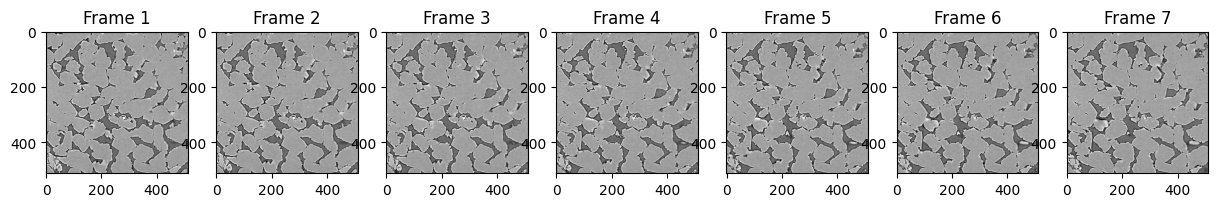

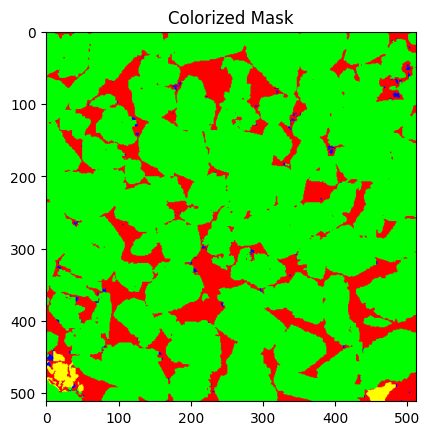

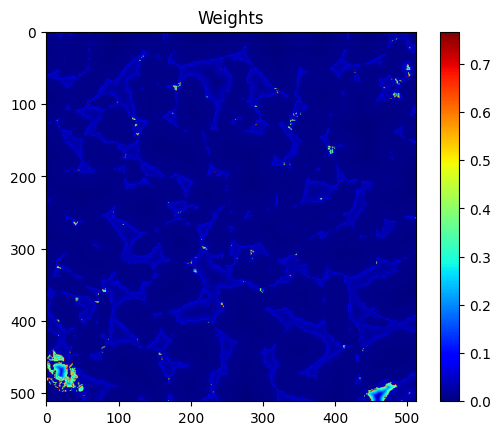

In [7]:
def visualize_generator_output(generator):
    inputs, labels, weights = next(generator)

    print("Input shape:", inputs.shape)
    print("Label shape:", labels.shape)
    print("Weights shape:", weights.shape)

    # Visualize the entire sequence
    sequence_length = inputs.shape[1]
    fig, axes = plt.subplots(1, sequence_length, figsize=(15, 3))
    for i in range(sequence_length):
        axes[i].imshow(inputs[0, i, :, :, 0], cmap='gray')
        axes[i].set_title(f'Frame {i+1}')
    plt.show()

    # Create a colorized mask
    colorized_mask = np.zeros((labels.shape[1], labels.shape[2], 3), dtype=np.uint8)
    for i in range(4):
        colorized_mask[labels[0, :, :, i] == 1] = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)][i]

    # Visualize the colorized mask
    plt.imshow(colorized_mask)
    plt.title('Colorized Mask')
    plt.show()

    # Visualize the weights
    plt.imshow(weights[0, :, :], cmap='jet')
    plt.title('Weights')
    plt.colorbar()
    plt.show()

# Visualize the output from the weighted train generator
visualize_generator_output(weighted_train_gen)

# Models

### LSTM U-Net

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


input_shape = (SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
num_classes = NUM_CLASSES

# The ConvLSTM block for the encoder
def conv_lstm_block(inputs, n_filters, kernel_size=3):
    lstm = layers.ConvLSTM2D(filters=n_filters, 
                             kernel_size=(kernel_size, kernel_size),
                             padding='same', 
                             dilation_rate=(1, 1),
                             return_sequences=True,
                             kernel_initializer='he_uniform',
                             kernel_regularizer=regularizers.l2(1e-4),
                             bias_regularizer=regularizers.l2(1e-4))(inputs)
    lstm = layers.BatchNormalization()(lstm)
    return lstm

# Reuse  2D conv_block for the decoder
def conv_block(inputs, n_filters, dropout_rate, kernel_size=3):
    conv = layers.Conv2D(n_filters, kernel_size=kernel_size, padding='same',
                         kernel_initializer='he_uniform',
                         kernel_regularizer=regularizers.l2(1e-4))(inputs)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Dropout(dropout_rate)(conv)
    return conv

def lstm_unet(input_shape=input_shape, n_filters=16, num_classes=4):
    inputs = layers.Input(input_shape)
    
    # --- Encoder ---
    c1 = conv_lstm_block(inputs, n_filters * 1, kernel_size=3)
    p1 = layers.MaxPooling3D(pool_size=(1, 2, 2))(c1) # Pool spatially, not temporally

    c2 = conv_lstm_block(p1, n_filters * 2, kernel_size=3)
    p2 = layers.MaxPooling3D(pool_size=(1, 2, 2))(c2)

    c3 = conv_lstm_block(p2, n_filters * 4, kernel_size=3)
    p3 = layers.MaxPooling3D(pool_size=(1, 2, 2))(c3)

    c4 = conv_lstm_block(p3, n_filters * 8, kernel_size=3)
    p4 = layers.MaxPooling3D(pool_size=(1, 2, 2))(c4)

    # --- Bottleneck ---
    bn = layers.ConvLSTM2D(filters=n_filters * 16, kernel_size=(3, 3), padding='same',
                           return_sequences=False, kernel_initializer='he_uniform')(p4)
    bn = layers.BatchNormalization()(bn)

    # --- Decoder ---
    # Get the last frame from each encoder stage for skip connections
    s1 = layers.Lambda(lambda x: x[:, -1, :, :, :])(c1)
    s2 = layers.Lambda(lambda x: x[:, -1, :, :, :])(c2)
    s3 = layers.Lambda(lambda x: x[:, -1, :, :, :])(c3)
    s4 = layers.Lambda(lambda x: x[:, -1, :, :, :])(c4)
    
    u6 = layers.Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(bn)
    u6 = layers.concatenate([u6, s4])
    c6 = conv_block(u6, n_filters * 8, dropout_rate=0.2)

    u7 = layers.Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, s3])
    c7 = conv_block(u7, n_filters * 4, dropout_rate=0.15)

    u8 = layers.Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, s2])
    c8 = conv_block(u8, n_filters * 2, dropout_rate=0.125)

    u9 = layers.Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, s1])
    c9 = conv_block(u9, n_filters * 1, dropout_rate=0.1125)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Build LSTM Unet Model
model = lstm_unet(input_shape=input_shape, n_filters=16, num_classes=NUM_CLASSES)

### Frame difference U-Net

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Lambda, BatchNormalization, Dropout, Subtract
from tensorflow.keras import regularizers

def frame_difference_unet(n_classes=4, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=1, sequence_length=SEQUENCE_LENGTH):

    if sequence_length < 2:
        raise ValueError("sequence_length must be at least 2 to compute frame differences.")

    inputs = Input((sequence_length, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # --- Pre-processing ---  
    # Get the last frame in the sequence to segment
    last_frame = Lambda(lambda x: x[:, -1, :, :, :], name='last_frame')(inputs)
    unet_input_tensors = [last_frame]

    # Calculate the difference between each consecutive pair of frames in reverse order.
    # For a sequence of length N, this will generate N-1 difference images.
    for i in range(1, sequence_length):
        frame_current = Lambda(lambda x, index: x[:, -index, :, :, :], 
                               arguments={'index': i}, 
                               name=f'diff_frame_current_{i}')(inputs)
        
        frame_prev = Lambda(lambda x, index: x[:, -index-1, :, :, :], 
                            arguments={'index': i}, 
                            name=f'diff_frame_previous_{i}')(inputs)
        
        # Calculate the difference, which highlights areas of change or motion.
        frame_diff = Subtract(name=f'frame_diff_{i}')([frame_current, frame_prev])
        unet_input_tensors.append(frame_diff)

    # Concatenate the last frame and all the difference images along the channel axis.
    unet_input = concatenate(unet_input_tensors, axis=-1)

    # --- Standard U-Net Architecture ---
    # --- Encoder ---
    # Level 1
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dilation_rate=(1, 1), kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4))(unet_input)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dilation_rate=(1, 1), kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4))(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Level 2
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dilation_rate=(1, 1), kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4))(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dilation_rate=(1, 1), kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4))(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # --- Bottleneck ---
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dilation_rate=(1, 1), kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4))(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.3)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dilation_rate=(1, 1), kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4))(c3)
    c3 = BatchNormalization()(c3)

    # --- Decoder ---
    # Level 2
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dilation_rate=(1, 1), kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4))(u4)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dilation_rate=(1, 1), kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4))(c4)
    c4 = BatchNormalization()(c4)

    # Level 1
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dilation_rate=(1, 1), kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4))(u5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', dilation_rate=(1, 1), kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4))(c5)
    c5 = BatchNormalization()(c5)

    outputs = Conv2D(n_classes, kernel_size=(1, 1), activation='softmax')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Build frame difference Unet Model
model = frame_difference_unet(
            n_classes=NUM_CLASSES,
            IMG_HEIGHT=IMG_HEIGHT,
            IMG_WIDTH=IMG_WIDTH,
            IMG_CHANNELS=1,
            sequence_length=SEQUENCE_LENGTH
        )


### 2-Stream U-Net

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np

def spatial_stream(input_shape, n_filters=16, num_classes=4):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = conv_block_2d(inputs, n_filters, dropout_rate=0.1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block_2d(p1, n_filters * 2, dropout_rate=0.1)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block_2d(p2, n_filters * 4, dropout_rate=0.2)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block_2d(p3, n_filters * 8, dropout_rate=0.2)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    bn = conv_block_2d(p4, n_filters * 16, dropout_rate=0.3)
    
    # Decoder
    u4 = upsample_block(bn, c4, n_filters * 8, dropout_rate=0.2)
    u3 = upsample_block(u4, c3, n_filters * 4, dropout_rate=0.15)
    u2 = upsample_block(u3, c2, n_filters * 2, dropout_rate=0.125)
    u1 = upsample_block(u2, c1, n_filters * 1, dropout_rate=0.1)
    
    # Output at full resolution
    spatial_output = layers.Conv2D(num_classes, (1, 1), activation='linear', 
                                   name='spatial_output')(u1)
    
    return models.Model(inputs, spatial_output, name='spatial_stream')

def changes_stream(input_shape, n_filters=8, num_classes=4):
    inputs = layers.Input(input_shape)
    
    # Initial 3D convolution to capture temporal patterns
    x = layers.Conv3D(n_filters, (3, 3, 3), padding='same', 
                      kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Reduce temporal dimension gradually
    # Max pooling in temporal dimension
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)  
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Further reduce temporal dimension
    x = layers.MaxPooling3D(pool_size=(2, 2, 1))(x) 
    
    # Reduce temporal dimension gradually
    # Max pooling in temporal dimension
    x = layers.MaxPooling3D(pool_size=(2, 2, 2 if inputs.shape[1] > 3 else 1))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Further reduce temporal dimension
    x = layers.MaxPooling3D(pool_size=(2, 2, 1 if inputs.shape[1] > 1 else 1))(x)  

    # Now we have single frame, squeeze temporal dimension
    x = layers.Reshape((x.shape[2], x.shape[3], x.shape[4]))(x)  # (H, W, channels)
    
    # Lightweight 2D processing
    x = layers.SeparableConv2D(n_filters * 4, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.SeparableConv2D(n_filters * 2, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    changes_output = layers.Conv2D(num_classes, (1, 1), activation='linear',
                                    name='changes_output')(x)
    
    return models.Model(inputs, changes_output, name='changes_stream')

def attention_gate(spatial_features, temporal_features, filters):
    # Transform both streams to same feature space
    spatial_transformed = layers.Conv2D(filters, (1, 1))(spatial_features)
    temporal_transformed = layers.Conv2D(filters, (1, 1))(temporal_features)
    
    # Add and apply attention
    combined = layers.Add()([spatial_transformed, temporal_transformed])
    attention_weights = layers.Activation('sigmoid')(combined)
    
    # Apply attention to temporal features
    gated_temporal = layers.Multiply()([temporal_features, attention_weights])
    
    return gated_temporal

def fusion_block(spatial_output, changes_output, num_classes):
    # Ensure both streams have same spatial dimensions
    if spatial_output.shape[1] != changes_output.shape[1]:
        changes_output = layers.UpSampling2D(
            size=(spatial_output.shape[1] // changes_output.shape[1], 
                  spatial_output.shape[2] // changes_output.shape[2])
        )(changes_output)
    
    # Apply attention gating
    gated_temporal = attention_gate(spatial_output, changes_output, 
                                   filters=num_classes)
    
    # Fusion strategies
    # Weighted sum (learnable weights)
    spatial_weight = layers.Conv2D(1, (1, 1), activation='sigmoid', 
                                   name='spatial_weight')(spatial_output)
    temporal_weight = layers.Conv2D(1, (1, 1), activation='sigmoid',
                                    name='temporal_weight')(gated_temporal)
    
    # Normalize weights to sum to 1
    total_weight = layers.Add()([spatial_weight, temporal_weight])
    spatial_weight_normalized = layers.Lambda(lambda x: x[0] / x[1])(
        [spatial_weight, total_weight])
    temporal_weight_normalized = layers.Lambda(lambda x: x[0] / x[1])(
        [temporal_weight, total_weight])
    
    # Weighted fusion
    weighted_spatial = layers.Multiply()([spatial_output, spatial_weight_normalized])
    weighted_temporal = layers.Multiply()([gated_temporal, temporal_weight_normalized])
    
    fused = layers.Add()([weighted_spatial, weighted_temporal])
        
    return fused

def build_two_stream_unet(input_shape, sequence_length=7, n_filters=16, num_classes=4):
    # Main input: full sequence
    main_input = layers.Input(input_shape)
    seq_length, img_height, img_width, img_channels = input_shape
    
    # Extract last frame for spatial stream
    spatial_input = layers.Lambda(lambda x: x[:, -1])(main_input)
    
    # Extract temporal context (center 7 frames)
    # Use frames leading up to the last frame
    start_idx = max(0, seq_length - sequence_length)
    end_idx = seq_length
    
    changes_input = layers.Lambda(
        lambda x: x[:, start_idx:end_idx] if (end_idx - start_idx) == sequence_length 
        else tf.pad(x[:, start_idx:end_idx], 
                   [[0, 0], [0, sequence_length - (end_idx - start_idx)], [0, 0], [0, 0], [0, 0]])
    )(main_input)
    
    # Build streams
    spatial_model = spatial_stream((img_height, img_width, img_channels), 
                                  n_filters, num_classes)
    changes_model = changes_stream((sequence_length, img_height, img_width, img_channels), 
                                    n_filters // 2, num_classes)  # Use fewer filters for lightweight stream
    
    # Get stream outputs
    spatial_output = spatial_model(spatial_input)
    changes_output = changes_model(changes_input)
    
    # Fusion with gating mechanism
    fused_output = fusion_block(spatial_output, changes_output, num_classes)
    
    # Final activation
    final_output = layers.Activation('softmax', name='final_output')(fused_output)
    
    # Create model
    model = models.Model(inputs=main_input, outputs=final_output, name='two_stream_unet')
    
    return model

def conv_block_2d(inputs, n_filters, dropout_rate, kernel_size=3):
    """Standard 2D convolution block"""
    conv = layers.Conv2D(n_filters, kernel_size=kernel_size, padding='same',
                         kernel_initializer='he_uniform',
                         kernel_regularizer=regularizers.l2(1e-4))(inputs)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Dropout(dropout_rate)(conv)
    
    conv = layers.Conv2D(n_filters, kernel_size=kernel_size, padding='same',
                         kernel_initializer='he_uniform',
                         kernel_regularizer=regularizers.l2(1e-4))(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Dropout(dropout_rate)(conv)
    return conv

def upsample_block(input_tensor, skip_tensor, n_filters, dropout_rate):
    """Upsampling block with skip connection"""
    u = layers.Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)
    u = layers.concatenate([u, skip_tensor])
    u = conv_block_2d(u, n_filters, dropout_rate)
    return u

# Build 2-stream Unet Model
input_shape = (SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model =  build_two_stream_unet(input_shape, sequence_length=7, n_filters=16, num_classes=4)

## Model Training and validation

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 512,    │          0 │ -                 │
│ (InputLayer)        │ 512, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diff_frame_current… │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diff_frame_previou… │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diff_frame_current… │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diff_frame_previou… │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diff_frame_current… │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diff_frame_previou… │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diff_frame_current… │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diff_frame_previou… │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diff_frame_current… │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diff_frame_previou… │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diff_frame_current… │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diff_frame_previou… │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last_frame (Lambda) │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frame_diff_1        │ (None, 512, 512,  │          0 │ diff_frame_curre… │
│ (Subtract)          │ 1)                │            │ diff_frame_previ… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frame_diff_2        │ (None, 512, 512,  │          0 │ diff_frame_curre… │
│ (Subtract)          │ 1)                │            │ diff_frame_previ… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frame_diff_3        │ (None, 512, 512,  │          0 │ diff_frame_curre

 Total params: 475,364 (1.81 MB)

 Trainable params: 474,084 (1.81 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
import os

# 1 Define a callback to reduce learning rate for a specific situation
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-5, verbose=2)

# 2 Define a callback to stop training process for a specific situation
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=1e-4, patience=8)

# 3 Define a callback to save history logs
csvl = CSVLogger("./history_log.csv", append=True)

# 4 Define a callback to save the best weights
checkpoint_dir = "./weights/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_filepath = os.path.join(checkpoint_dir, "kaggle/working/weights/best_weights.keras")
chp = ModelCheckpoint(checkpoint_filepath, monitor='loss', verbose=1, save_weights_only=False, save_best_only=True, mode='auto')

In [ ]:
# Training & validation procedure
weighted_train_gen = weighted_sequence_generator(train_gen)
weighted_val_gen   = weighted_sequence_generator(val_gen)

nb_epoch = 250

# Train the model
history = model.fit(
    weighted_train_gen,
    steps_per_epoch=int(1.6*36 // BATCH_SIZE),

    validation_data=weighted_val_gen,
    validation_steps=int(0.4*36 // BATCH_SIZE),

    epochs=nb_epoch, 
    
    verbose=1,
        
    callbacks=[ # Setting callbacks
        csvl,
        rlr,
        chp,
        es
    ]   
)


In [ ]:
# Get the history of training and validation loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Evaluation

In [2]:
# Due to RAM limits
import gc
gc.collect()

200

### Test data preparation

In [4]:
import os
import shutil
import re
from pathlib import Path

# =========================
# CONFIG
# =========================
ROOT_DIR = Path("/home/ridho/thesis/kaggle/working")
OUTPUT_DIR = ROOT_DIR / "subsequences/test"
SAMPLES = ["sample_c"]
AXES = ["X", "Y", "Z"]
SEQUENCE_LENGTH = 624

OUTPUT_DIR.mkdir(exist_ok=True)

# =========================
# HELPERS
# =========================
def extract_index(filename):
    """
    Extract slice index from filename
    Example: Bentheimer_A_X_624123.png -> 624123
    """
    match = re.search(r"_(\d+)\.png$", filename)
    return int(match.group(1)) if match else None

# =========================
# MAIN LOGIC
# =========================
sequence_counter = 1

for sample in SAMPLES:
    sample_dir = ROOT_DIR / sample
    input_dir = sample_dir / "inputs"
    label_dir = sample_dir / "labels"

    for axis in AXES:
        # collect files for this axis
        input_files = [
            f for f in os.listdir(input_dir)
            if f"_{axis}_" in f
        ]

        # sort by slice index
        input_files.sort(key=extract_index)

        if len(input_files) != SEQUENCE_LENGTH:
            print(f"⚠️ Warning: {sample} axis {axis} has {len(input_files)} files")

        # create output folders
        seq_name = f"sequence_{sequence_counter:03d}"
        seq_input_dir = OUTPUT_DIR / seq_name / "inputs"
        seq_label_dir = OUTPUT_DIR / seq_name / "labels"

        seq_input_dir.mkdir(parents=True, exist_ok=True)
        seq_label_dir.mkdir(parents=True, exist_ok=True)

        # copy files
        for fname in input_files:
            shutil.copy(
                input_dir / fname,
                seq_input_dir / fname
            )
            shutil.copy(
                label_dir / fname,
                seq_label_dir / fname
            )

        print(f"Created {seq_name} from {sample}, axis {axis}")
        sequence_counter += 1

print("\n🎉 Dataset reorganization complete.")


Created sequence_001 from sample_c, axis X
Created sequence_002 from sample_c, axis Y
Created sequence_003 from sample_c, axis Z

🎉 Dataset reorganization complete.


### Test data generator

In [5]:
import os
import numpy as np
import tensorflow as tf
tf.keras.config.enable_unsafe_deserialization()
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt


# TEST DATA GENERATOR 
class SlidingWindowDataGenerator(Sequence):
    def __init__(self, data_dir, batch_size, sequence_length, image_size, mode='test'):
        """
        Initialize the data generator.
        
        Args:
            data_dir (str): Path to the dataset directory.
            batch_size (int): Number of samples per batch.
            sequence_length (int): Number of frames in the input sequence (T).
            image_size (tuple): Tuple specifying the image size (height, width).
            mode (str): One of 'train', 'val', or 'test' to specify the dataset split.
        """
        self.data_dir = os.path.join(data_dir, mode)
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.image_size = image_size
        self.mode = mode
        self.sequences = self._load_sequences()
        self.num_samples = len(self.sequences)
    
    def _load_sequences(self):
        """
        Load all sequences and corresponding frame paths.
        """
        sequences = []
        for sequence_dir in os.listdir(self.data_dir):
            sequence_path = os.path.join(self.data_dir, sequence_dir)
            images_dir = os.path.join(sequence_path, "inputs")
            masks_dir = os.path.join(sequence_path, "labels")
            images = sorted([os.path.join(images_dir, img) for img in os.listdir(images_dir) if img.endswith(".png")])
            masks = sorted([os.path.join(masks_dir, mask) for mask in os.listdir(masks_dir) if mask.endswith(".png")])
            for i in range(self.sequence_length - 1, len(images)):
                sequences.append((images[i - self.sequence_length + 1:i + 1], masks[i]))
        return sequences
    
    def __len__(self):
        """
        Return the number of batches per epoch.
        """
        return int(np.ceil(self.num_samples / self.batch_size))
    
    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        batch_sequences = self.sequences[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self._generate_data(batch_sequences)
        return X, y
    
    def _generate_data(self, batch_sequences):
        """
        Generate data for a batch of sequences.
        """
        X = []
        y = []
        for sequence in batch_sequences:
            images, mask = sequence
            image_sequence = [self._load_and_preprocess(img) for img in images]
            mask = self._load_and_preprocess(mask, is_mask=True)
            X.append(image_sequence)
            y.append(mask)
        return np.array(X), np.array(y)
    
    def _load_and_preprocess(self, filepath, is_mask=False):
        img = load_img(filepath, target_size=self.image_size, color_mode='grayscale')
        img_array = img_to_array(img).astype('float32')
        if is_mask:
            img_array = img_array.squeeze()  # Remove the extra channel for grayscale
            img_array = to_categorical(img_array, num_classes=4)  # Convert to one-hot encoding
        else:
            img_array /= 255.0  # Normalize image pixel values to [0, 1]
        return img_array
    
    def on_epoch_end(self):
        """
        Shuffle data at the end of each epoch (for training mode).
        """
        if self.mode == 'train':
            np.random.shuffle(self.sequences)

def evaluate_test_metrics(test_generator, model, num_classes):
    """
    Evaluate metrics and generate a confusion matrix in a memory-efficient way.
    
    Args:
        test_generator (keras.utils.Sequence): Data generator for the test dataset.
        model (keras.Model): Trained model for prediction.
        num_classes (int): Number of classes.

    Returns:
        tuple: (metrics dict, overall_accuracy, iou_metrics dict, confusion_matrix)
    """
    # Initialize one large confusion matrix to accumulate results
    total_cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    # Loop through the test generator
    for i in range(len(test_generator)):
        # Load a batch of data
        X_batch, y_batch = test_generator[i]  # y_batch is one-hot encoded

        # Predict the batch
        y_pred_batch = model.predict(X_batch)  # Shape: (batch_size, height, width, num_classes)
        
        # Convert predictions and ground truths to class indices
        y_pred_classes = np.argmax(y_pred_batch, axis=-1)
        y_true_classes = np.argmax(y_batch, axis=-1)

        # Flatten the arrays to compute confusion matrix
        y_true_flat = y_true_classes.ravel()
        y_pred_flat = y_pred_classes.ravel()

        # Calculate confusion matrix for the current batch
        # 'labels' ensures the matrix is always N_classes x N_classes
        batch_cm = confusion_matrix(y_true_flat, y_pred_flat, labels=range(num_classes))

        # Add to the total confusion matrix
        total_cm += batch_cm

    # --- Selesai loop ---
    # Sekarang hitung semua metrik dari `total_cm`
    
    metrics = {}
    iou_metrics = {}
    iou_values = []
    
    for class_id in range(num_classes):
        # Ambil TP, FP, FN dari confusion matrix
        tp = total_cm[class_id, class_id]
        fp = total_cm[:, class_id].sum() - tp
        fn = total_cm[class_id, :].sum() - tp
        tn = total_cm.sum() - (tp + fp + fn)

        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
        class_accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0.0
        
        # Calculate IoU
        intersection = tp
        union = tp + fp + fn
        iou = intersection / union if union != 0 else 0.0
        iou_values.append(iou)

        metrics[f"Class {class_id}"] = {
            "Accuracy": class_accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score,
            "IoU": iou
        }
        
        iou_metrics[f"Class {class_id}"] = iou

    # Calculate mean IoU
    mean_iou = np.mean(iou_values)
    iou_metrics["Mean IoU"] = mean_iou

    # Overall accuracy
    total_correct = np.diag(total_cm).sum()
    total_pixels = total_cm.sum()
    overall_accuracy = total_correct / total_pixels if total_pixels != 0 else 0.0

    return metrics, overall_accuracy, iou_metrics, total_cm

def plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion Matrix'):
    # Increased figure size slightly to accommodate larger text
    plt.figure(figsize=(12, 10))
    
    FONT_SCALE = 16          # Size of numbers inside the matrix

    if normalize:
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_norm = np.nan_to_num(cm_norm)
        
        annot_labels = np.array([
            ["{:.2%}".format(value).replace('.', ',') for value in row] 
            for row in cm_norm
        ])
        
        # annot_kws={"size": FONT_SCALE} controls the inner text size
        sns.heatmap(cm_norm, annot=annot_labels, fmt='', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names,
                    annot_kws={"size": FONT_SCALE}) 
        
        plt.title(title + " (Normalized)")
        
    else:
        annot_labels = np.array([
            ["{:,}".format(value).replace(',', '.') for value in row] 
            for row in cm
        ])
        
        sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Oranges', 
                    xticklabels=class_names, yticklabels=class_names,
                    annot_kws={"size": FONT_SCALE})
        
        plt.title(title + " (Pixel Count)")

    # Axis Labels
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')   
    plt.show()

2026-01-12 21:48:33.049600: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Confusion matrix and metrics evaluation

In [ ]:
model_path = "/home/ridho/thesis/seminar_revision/weights/lstm_no_aug_5.keras"
model = tf.keras.models.load_model(model_path, compile=False)

# Load data generator
test_generator = SlidingWindowDataGenerator(
    data_dir='kaggle/working/subsequences',
    batch_size=1, 
    sequence_length=5,
    image_size=(512, 512),
    mode='test'
)

class_names = ['Pore', 'Quartz', 'Clay', 'Feldspar']
num_classes = len(class_names)

print("Starting evaluation...")
metrics, overall_accuracy, iou_metrics, cm = evaluate_test_metrics(test_generator, model, num_classes)
print("Evaluation finished.")

# Print the results
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
print(f"Mean IoU: {iou_metrics['Mean IoU']:.4f}")

print("\nIoU per class:")
for class_name, iou_value in iou_metrics.items():
    if class_name != "Mean IoU":
        print(f"{class_name}: {iou_value:.4f}")

print("\nMetrics per class:")
for class_name, class_metrics in metrics.items():
    print(f"{class_name}:")
    for metric_name, metric_value in class_metrics.items():
        print(f" {metric_name}: {metric_value:.4f}") 

# Confusion Matrix visualization
plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion Matrix')
plot_confusion_matrix(cm, class_names, normalize=True, title='Normalized Confusion Matrix')

I0000 00:00:1768229324.832180   11713 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11478 MB memory:  -> device: 0, name: AMD Radeon RX 9060 XT, pci bus id: 0000:08:00.0


Starting evaluation...


I0000 00:00:1768229328.038360   14029 service.cc:148] XLA service 0x328efac0 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768229328.038403   14029 service.cc:156]   StreamExecutor device (0): AMD Radeon RX 9060 XT, AMDGPU ISA version: gfx1200
2026-01-12 21:48:48.191376: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1768229328.956096   14029 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━